In [1]:
%matplotlib inline
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!pip install pennylane
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [4]:
n_qubits = 8                # Number of qubits
step = 0.0006               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 10              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
import jax  # require for Just In Time (JIT) compilation
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)


In [5]:
dev = qml.device("lightning.qubit", wires=n_qubits)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "./data/braintumor/two_classes"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [10]:
dataset_sizes.get('validation')


705

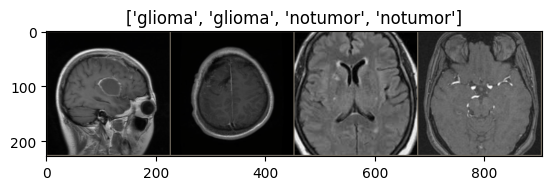

In [23]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [24]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


In [ ]:
# quantum dropout
def true_cond(angle):
    # necessary for using an if statement within jitted function
    # exploiting jax.lax.cond
    # if this function is assessed the rotation is dropped
    return 0.0


def false_cond(angle):
    # necessary for using an if statement within jitted function
    # exploiting jax.lax.cond
    # if this function is assessed the rotation is kept
    return angle

def var_ansatz(
    theta, wires, rotations=[qml.RX], entangler=qml.CNOT, keep_rotation=None
):

    """
    if the value is negative the rotation is dropped (rotation dropout), otherwise it is applied.

    Params:
    - theta: variational angles that will undergo optimization
    - wires: list of qubits (wires)
    - rotations: list of rotation kind per each `inner_layer`
    - entangler: entangling gate
    - keep_rotation: list of lists. There is one list per each `inner_layer`.
                    In each list there are indexes of the rotations that we want to apply.
                    Some of these values may be substituted by -1 value
                    which means that the rotation gate wont be applied (dropout).
    """

    # the length of `rotations` defines the number of inner layers
    N = len(wires)
    assert len(theta) == 3 * N
    wires = list(wires)

    counter = 0
    # keep_rotations contains a list per each inner_layer
    for rots in keep_rotation:
        # we cicle over the elements of the lists inside keep_rotation
        for qb, keep_or_drop in enumerate(rots):
            rot = rotations[counter]  # each inner layer can have a different rotation

            angle = theta[counter * N + qb]
            # conditional statement implementing dropout
            # if `keep_or_drop` is negative the rotation is dropped
            angle_drop = jax.lax.cond(keep_or_drop < 0, true_cond, false_cond, angle)
            rot(angle_drop, wires=wires[qb])
        for qb in wires[:-1]:
            entangler(wires=[wires[qb], wires[qb + 1]])
        counter += 1

In [ ]:
# jax pmap
# jax vmap

In [1]:
core_node = qml.from_qasm(core_node_cut) 

@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    
    core_node(wires=range(n_qubits))

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

NameError: name 'qml' is not defined

In [26]:
class HybridModel(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [27]:
model_hybrid = models.resnet18(weights='ResNet18_Weights.DEFAULT')

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = HybridModel()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [28]:
criterion = nn.CrossEntropyLoss()

In [29]:
# optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
operator_pool = [qml.RY]
opt = AdaptiveOptimizer()

We schedule to reduce the learning rate by a factor of
`gamma_lr_scheduler` every 10 epochs.


In [30]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss
      
            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

We are ready to perform the actual training process.


In [32]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/10 Loss: 0.4706 Acc: 0.7816        
Phase: validation   Epoch: 1/10 Loss: 0.1608 Acc: 0.9716        
Phase: train Epoch: 2/10 Loss: 0.3586 Acc: 0.8488        
Phase: validation   Epoch: 2/10 Loss: 0.2462 Acc: 0.8894        
Phase: train Epoch: 3/10 Loss: 0.3317 Acc: 0.8649        
Phase: validation   Epoch: 3/10 Loss: 0.1041 Acc: 0.9773        
Phase: train Epoch: 4/10 Loss: 0.2959 Acc: 0.8721        
Phase: validation   Epoch: 4/10 Loss: 0.1034 Acc: 0.9773        
Phase: train Epoch: 5/10 Loss: 0.3152 Acc: 0.8697        
Phase: validation   Epoch: 5/10 Loss: 0.1000 Acc: 0.9773        
Phase: train Epoch: 6/10 Loss: 0.3263 Acc: 0.8680        
Phase: validation   Epoch: 6/10 Loss: 0.2929 Acc: 0.8823        
Phase: train Epoch: 7/10 Loss: 0.3108 Acc: 0.8721        
Phase: validation   Epoch: 7/10 Loss: 0.1286 Acc: 0.9801        
Phase: train Epoch: 8/10 Loss: 0.3220 Acc: 0.8687        
Phase: validation   Epoch: 8/10 Loss: 0.1131 Acc: 0.9759       

Visualizing the model predictions
=================================


We first define a visualization function for a batch of test data.


In [33]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

Finally, we can run the previous function to see a batch of images with
the corresponding predictions.


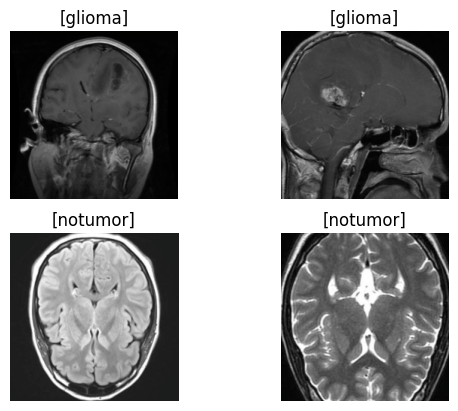

In [34]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()